<a href="https://colab.research.google.com/github/manu9418/IRH/blob/main/MAIRH_TF_correlationmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation Map

In [ ]:
# !apt-get -qq install -y python-cartopy python3-cartopy 
# !apt-get -qq install -y install cftime netcdf4
!apt-get install libproj-dev proj-data proj-bin
# !apt-get install -qq libgdal-dev libproj-dev
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
# !apt-get -qq install -y python-cartopy python3-cartopy #https://stackoverflow.com/questions/60342880/using-cartopy-on-google-colab-crashes-every-time
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely #!pip install --no-binary shapely shapely --force # https://github.com/SciTools/cartopy/issues/1490
# !pip install cartopy==0.18.0 #17

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (71.3 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

In [ ]:
# import the modules we need
import numpy as np
import io, requests
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import warnings
warnings.filterwarnings("ignore")

link_base = 'http://iridl.ldeo.columbia.edu/SOURCES/'
ERSSTv5_sst = link_base + '.NOAA/.NCDC/.ERSST/.version5/.sst/dods'
ERSSTv5_sst_clim = link_base + '.NOAA/.NCDC/.ERSST/.version5/.sst/yearly-climatology/dods'
ERSSTv5_sst_anom = link_base + '.NOAA/.NCDC/.ERSST/.version5/.anom/dods'
ERSSTv5_sst_anom_clim = link_base +  '.NOAA/.NCDC/.ERSST/.version5/.anom/yearly-climatology/dods'
CoSch = link_base + '.INPE/.CPTEC/.latam/.CoSch/.monthly/.rainfall/dods'
# GPCP = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V1DD/.V1p3/.precip/dods'

## Ejemplo 1

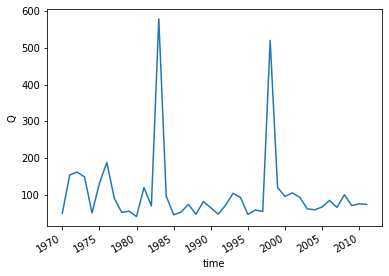

In [ ]:
## Ingreso de datos desde csv:
year_ini = 1970;
year_fin = 2011;
df = pd.read_csv("/content/drive/MyDrive/Data/runoff.txt", names=['Q'])
time = pd.date_range(datetime.datetime(year_ini,1,1), datetime.datetime(year_fin,1,1), freq='AS-JAN')
df=df.set_index(time)
Q = xr.DataArray(df.Q, dims='time', coords={'time':time})
Q.plot()

In [ ]:
ds = xr.open_dataset(ERSSTv5_sst, decode_times=False)
ds.T.attrs['calendar'] = '360_day'
ds_dims=ds.dims
##Ahora le decimos a xarray que interprete los tiempos
ds = xr.decode_cf(ds)
ds = ds.rename({'X':'lon','Y':'lat','T':'time'})
ds = ds.isel(zlev=0)
for i in ds_dims:
  if i=='zlev':
    #print(i)
    #ds = ds.drop_dims('zlev')
    ds = ds.drop_vars('zlev') 
    # ds= ds.reset_coords('zlev', drop=True)
ds = ds.sel(time=slice('1970','2011'))
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 504)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1970-01-16 00:00:00 ... 2011-12-16 00:00:00
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [ ]:
ds_DJF = ds.where(ds['time.season'] == 'DJF') 
#select winter season since correlation is strongest here
ds_DJF_year = ds_DJF.groupby('time.year').mean('time') 
#average over the year (over each season)

In [ ]:
ds_DJF_year=ds_DJF_year.sst

In [ ]:
# first, we make an empty array that we will fill with the correlation coefficients of each grid point
cor_map = ds_DJF_year[0,:,:] * 0.
# for loops over lats and lons
for j in np.arange(len(ds_DJF_year.lat)):
    for i in np.arange(len(ds_DJF_year.lon)):
        cor_map.values[j, i] = np.corrcoef(ds_DJF_year.values[:, j, i], Q.values)[0, 1]

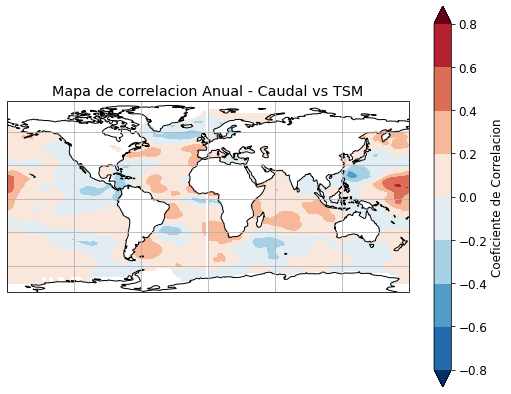

In [ ]:
plt.rcParams.update({'font.size': 12})
fig10 = plt.figure(figsize=(9, 7))
ax10 = plt.axes(projection=ccrs.PlateCarree())
ax10.coastlines();
ax10.gridlines();
cs = cor_map.plot.contourf(ax=ax10, transform=ccrs.PlateCarree(),\
                      cbar_kwargs={'label':'Coeficiente de Correlacion'},\
                      levels=np.linspace(-0.8, 0.8, 9), extend='both')
plt.title("Mapa de correlacion Anual - Caudal vs TSM");
plt.show()

## Ejemplo 2

In [ ]:
# This just reads the data from an url
# data from http://www.cpc.ncep.noaa.gov/data/teledoc/nao.shtml
url = 'http://ftp.cpc.ncep.noaa.gov/wd52dg/data/indices/nao_index.tim'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, skiprows=7)
# Parse the time and convert to xarray
time = pd.to_datetime(df.YEAR.astype(str) + '-' + df.MONTH.astype(str))
nao = xr.DataArray(df.INDEX, dims='time', coords={'time':time})
# Select the ERA period
nao = nao.sel(time=slice('1979', '2014'))
nao

<xarray.DataArray 'INDEX' (time: 432)>
array([-2.12, -1.2 ,  0.41, -2.01, -0.9 ,  1.92,  0.86,  1.11,  1.13,
        0.18,  0.42,  0.84, -1.38, -0.39, -0.73,  1.26, -1.34, -0.07,
       -0.39, -3.01,  0.79, -1.41, -0.52,  0.63, -0.08,  0.6 , -1.65,
        0.25,  0.24, -0.15,  0.08,  0.38, -1.27, -0.96, -0.53, -0.11,
       -1.55,  0.86,  0.8 , -0.04, -0.44, -1.34,  1.18,  0.21,  1.86,
       -0.29,  1.55,  1.56,  1.34, -1.04,  0.59, -1.07, -0.01,  1.31,
        1.22,  1.95, -0.95,  1.22, -1.16,  0.18,  1.42,  0.37, -0.79,
       -0.45,  0.55, -0.12, -0.04,  1.35,  0.31,  0.43, -0.2 , -0.09,
       -2.38, -1.  , -0.19,  0.2 , -0.4 , -0.5 ,  1.25, -0.74, -0.36,
        1.49, -0.84,  0.11,  0.78, -1.58,  1.39, -0.79,  0.84,  1.54,
        0.15, -1.53, -0.95,  2.2 ,  2.27,  0.83, -1.85, -1.27, -0.26,
        2.03,  0.96, -1.53,  0.55, -1.19, -1.04,  0.66,  0.06,  0.21,
        0.68,  0.42, -0.58, -1.42,  0.64,  1.19, -0.32, -0.07, -0.82,
       -0.66, -0.49,  0.48,  0.85,  1.82,  1.54,  0.16,  1.33,  0.03,
        1.  , -0.11,  2.15,  0.48,  0.03, -1.15,  0.7 ,  1.16,  1.13,
        2.03, -1.37,  0.29,  0.56,  1.12,  1.18,  0.76, -0.39,  0.11,
        0.49,  0.74, -0.61,  0.17,  0.12, -0.52, -0.46,  1.46,  0.61,
        0.3 ,  0.37,  0.34, -0.66,  0.77,  0.51,  1.88,  2.49,  0.51,
        0.19,  0.97, -0.28, -1.4 ,  1.12,  0.35,  1.35,  0.12,  0.3 ,
        0.91, -0.67, -0.29, -3.14,  0.03, -0.41, -0.26,  2.56,  1.36,
...
        0.19,  1.48,  0.4 , -0.18,  1.52,  0.28, -1.  , -0.5 , -0.06,
        1.51, -1.1 , -0.63, -0.22,  0.07, -1.73, -0.15,  0.03,  0.11,
       -0.22, -0.22, -0.49,  0.25,  0.53, -0.86,  0.  ,  0.8 ,  0.32,
        1.14, -0.15,  0.69,  0.65,  0.36, -0.54, -1.97, -0.32, -0.96,
       -0.32,  0.26, -0.07, -0.34,  0.06,  0.24,  0.16, -0.22,  0.16,
       -0.86,  0.77,  0.5 , -0.85, -0.6 ,  0.67,  1.11,  0.23, -0.59,
        1.16, -0.74,  0.52, -0.69,  0.63,  1.03,  1.26, -0.51, -2.32,
       -0.47, -1.11,  0.26, -0.48,  0.35,  0.76, -0.55, -0.46, -0.5 ,
        0.97, -1.02, -1.75,  1.2 , -1.01,  1.15,  0.93, -2.35, -1.43,
       -1.92,  0.33,  1.15, -0.25, -0.98,  1.11,  0.04,  0.66, -1.01,
       -0.55, -0.31,  0.85,  1.  ,  0.48,  0.23,  0.53,  0.38, -0.32,
       -1.31, -1.55, -1.09, -1.24, -1.62,  1.14,  0.47, -0.47, -0.35,
       -0.52, -0.38,  0.19, -0.36,  1.61, -0.91, -2.11, -0.37,  1.62,
       -0.61, -0.16, -1.88, -1.8 , -2.69, -1.33, -0.93, -1.33, -0.52,
       -0.39, -1.69, -0.62, -0.5 , -1.84, -1.8 , -1.53,  0.35,  0.24,
        2.55, -0.01, -0.98, -1.48, -1.85,  0.67,  0.94,  1.3 ,  2.25,
        0.86,  0.03,  0.93,  0.37, -0.79, -2.25, -1.29, -1.39, -0.43,
       -1.73, -0.74,  0.07, -0.11, -0.96, -2.09,  0.6 ,  0.58,  0.83,
        0.7 ,  1.12,  0.38, -0.88,  0.81,  0.79, -0.17,  1.07,  0.44,
        0.19, -0.8 , -0.67,  0.21, -2.28,  1.72, -0.87,  0.58,  1.63])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01

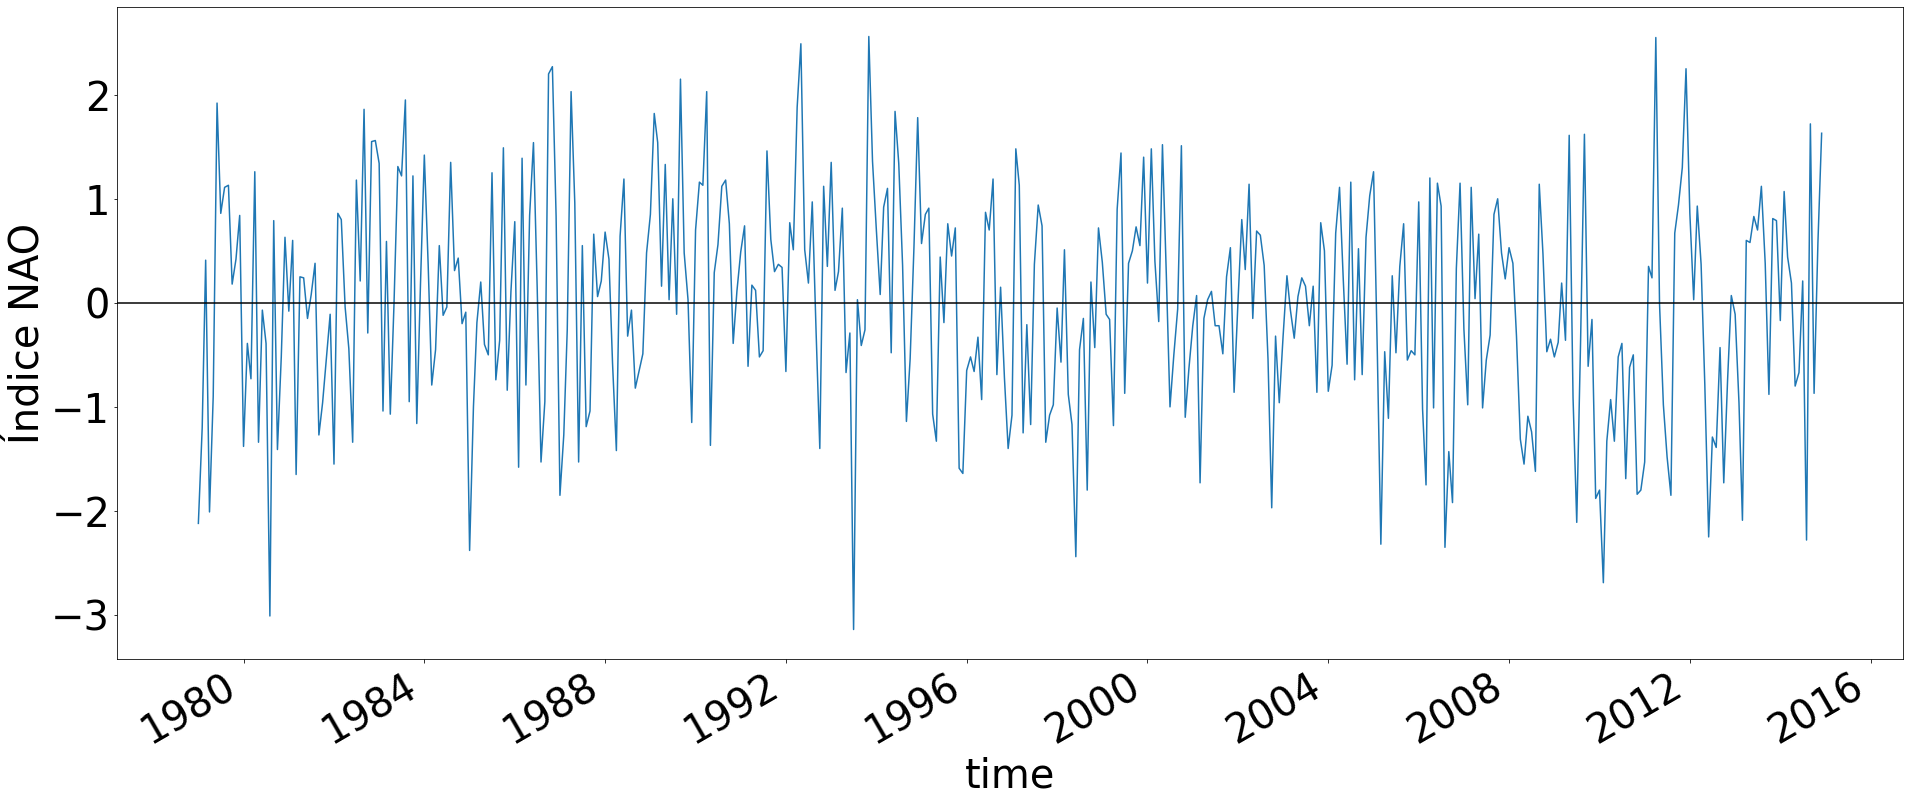

In [ ]:
plt.rcParams.update({'font.size': 40})
fig7, ax7 = plt.subplots(1,1, **dict(figsize=(32,12)))
nao.sel(time=slice(datetime.datetime(1979,1,1), datetime.datetime(2014,12,1))).plot(ax=ax7)
plt.axhline(0, color = 'k');
plt.ylabel('Índice NAO');
plt.show()

In [ ]:
!pip install cftime

In [ ]:
ds = xr.open_dataset(ERSSTv5_sst, decode_times=False)
ds.T.attrs['calendar'] = '360_day'
ds_dims=ds.dims
##Ahora le decimos a xarray que interprete los tiempos
ds = xr.decode_cf(ds)
ds = ds.rename({'X':'lon','Y':'lat','T':'time'})
ds = ds.isel(zlev=0)
for i in ds_dims:
  if i=='zlev':
    #print(i)
    #ds = ds.drop_dims('zlev')
    ds = ds.drop_vars('zlev') 
    # ds= ds.reset_coords('zlev', drop=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2015)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1854-01-16 00:00:00 ... 2021-11-16 00:00:00
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [ ]:
sst_clim = ds.sst.sel(time = slice('1979','2014'))
# sst_clim.isel(time=0).plot()

In [ ]:
#sst_clim_crop = ds.sst.sel(lat = slice(-60,20), lon = slice(200,330), time = slice('1981','2020'))
#sst_clim_crop.sel(time=slice('2017-01','2017-01')).plot()
sst_clim_mean = sst_clim.mean(dim = ['lat', 'lon'])

In [ ]:
sst_clim_mean = sst_clim_mean.where(sst_clim_mean['time.season'] == 'DJF') 
#select winter season since correlation is strongest here
sst_clim_mean = sst_clim_mean.groupby('time.year').mean('time') 
#average over the year (over each season)

nao = nao.where(nao['time.season'] == 'DJF').groupby('time.year').mean('time')  
# nao.groupby('time.season')

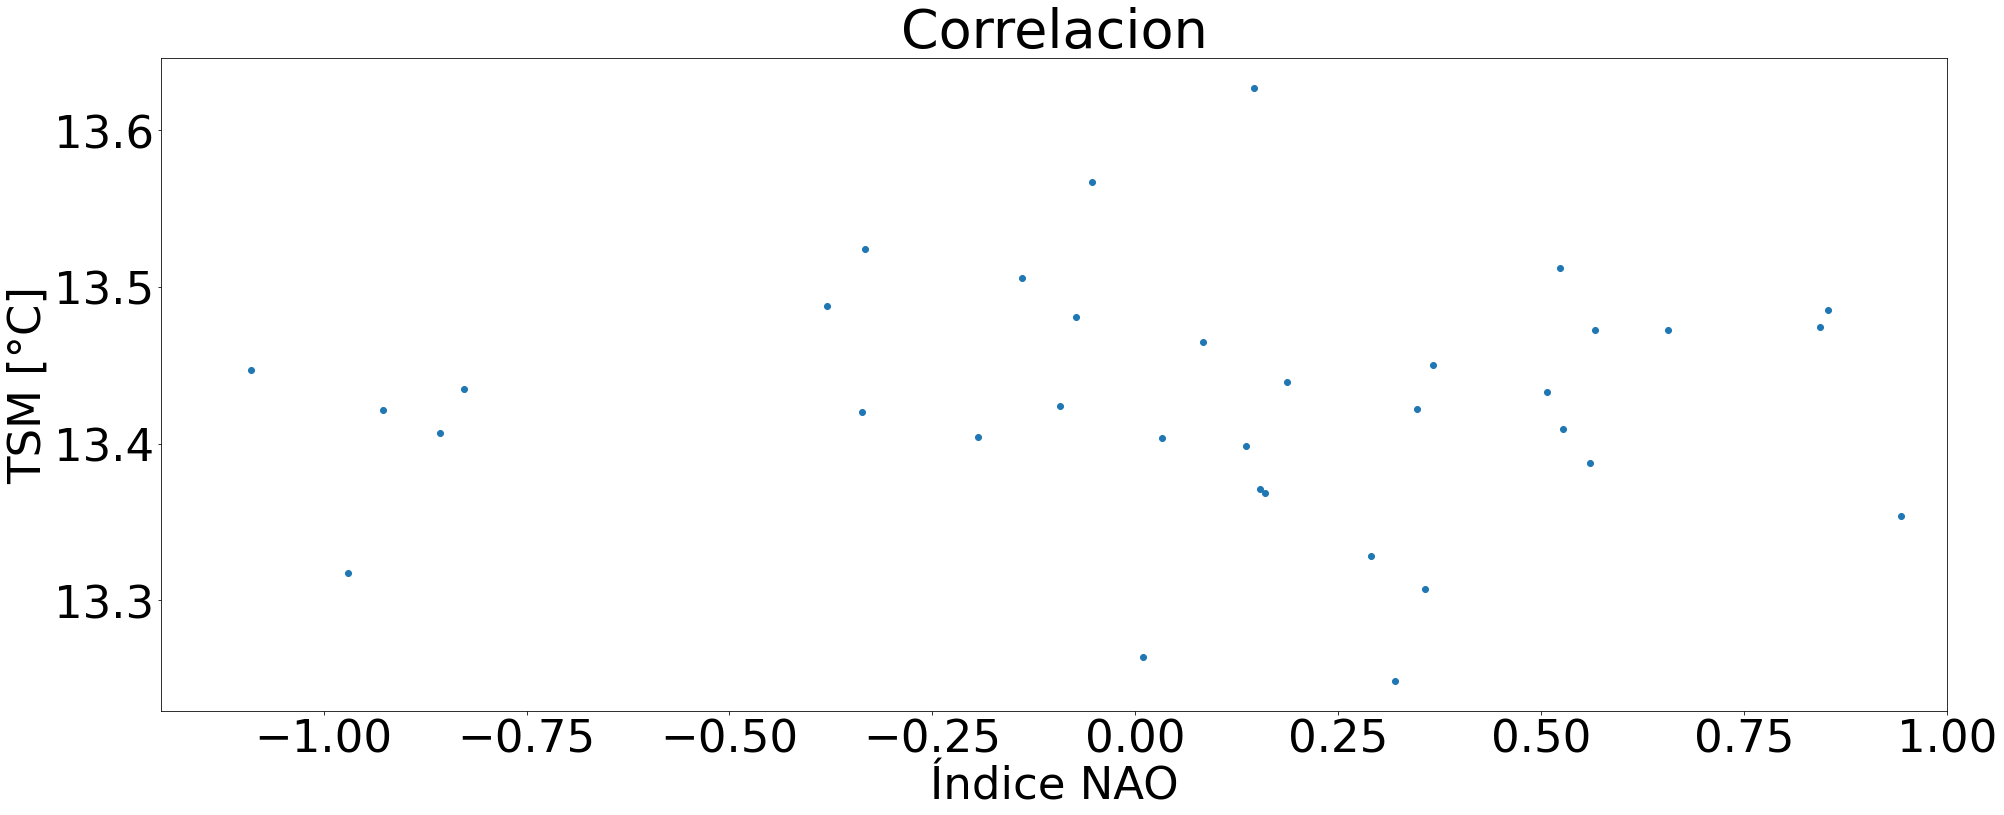

In [ ]:
plt.rcParams.update({'font.size': 45})
fig8, ax8 = plt.subplots(1,1, **dict(figsize=(32,12)))
ax8.scatter(nao, sst_clim_mean)
plt.xlabel('Índice NAO');
plt.ylabel('TSM [°C]');
plt.title('Correlacion')
plt.xlim([-1.2,1.0]);
plt.show()

In [ ]:
sst_clim_DJF = sst_clim.where(sst_clim['time.season'] == 'DJF') 
#select winter season since correlation is strongest here
sst_clim_DJF_year = sst_clim_DJF.groupby('time.year').mean('time') 
#average over the year (over each season)

In [ ]:
# first, we make an empty array that we will fill with the correlation coefficients of each grid point
cor_map = sst_clim_DJF_year[0,:,:] * 0.
# for loops over lats and lons
for j in np.arange(len(sst_clim_DJF_year.lat)):
    for i in np.arange(len(sst_clim_DJF_year.lon)):
        cor_map.values[j, i] = np.corrcoef(sst_clim_DJF_year.values[:, j, i], nao.values)[0, 1]

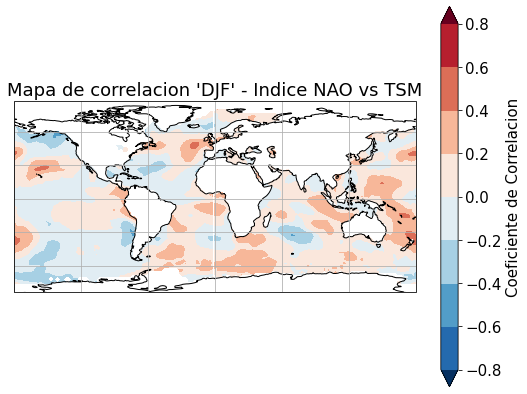

In [ ]:
plt.rcParams.update({'font.size': 15})
fig9 = plt.figure(figsize=(9, 7))
ax9 = plt.axes(projection=ccrs.PlateCarree())
ax9.coastlines(); 
ax9.gridlines();
cs = cor_map.plot.contourf(ax=ax9, transform=ccrs.PlateCarree(),\
                      cbar_kwargs={'label':'Coeficiente de Correlacion'},\
                      levels=np.linspace(-0.8, 0.8, 9), extend='both')
plt.title("Mapa de correlacion 'DJF' - Indice NAO vs TSM");
plt.show()